In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import pickle

In [40]:
df = pd.read_csv("Data/train.csv", index_col="PassengerId")

# EDA and Preprocessing

### Variable Descriptions

| Variable | Definition                                 | Key                                            |
| ---------| ------------------------------------------ | ---------------------------------------------- |
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |	                                             |
| Age      | Age in year                                |	                                             |
| sibsp    | # of siblings / spouses aboard the Titanic |		                                         |
| parch    | # of parents / children aboard the Titanic |		                                         |
| ticket   | Ticket number                              |		                                         |
| fare     | Passenger fare                             |	                                             |	
| cabin    | Cabin number                               |	                                             |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |


### Variable Notes
| **variable** | **Note** | **Additional Info** |
| -------------| -------- | ------------------- |
| ***pclass*** | A proxy for socio-economic status (SES) | <ul><li>1st = Upper</li><li>2nd = Middle</li><li>3rd = Lower</li></ul> |
| ***age***| Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 |
| ***sibsp*** | The dataset defines family relations in this way ==> | <ul><li>Sibling = brother, sister, stepbrother, stepsister</li><li>Spouse = husband, wife (mistresses and fiancés were ignored)</li></ul> |
| parch    | The dataset defines family relations in this way ==> |<ul><li>Paent = mother, father</li><li>Child = daughter, son, stepdaughter, stepson</li></ul>|

### Split Data and Take a Look

In [41]:
# Let's split data in two
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Survived'])

In [42]:
print('Train data traget distribution:', train_df.Survived.value_counts(), end='\n\n')
print('Test data traget distribution:', test_df.Survived.value_counts())

Train data traget distribution: Survived
0    439
1    273
Name: count, dtype: int64

Test data traget distribution: Survived
0    110
1     69
Name: count, dtype: int64


In [43]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S
856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S


In [44]:
# Check train_df for missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 693 to 508
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Name      712 non-null    object 
 3   Sex       712 non-null    object 
 4   Age       575 non-null    float64
 5   SibSp     712 non-null    int64  
 6   Parch     712 non-null    int64  
 7   Ticket    712 non-null    object 
 8   Fare      712 non-null    float64
 9   Cabin     160 non-null    object 
 10  Embarked  710 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [45]:
# Check test_df for missing values
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 566 to 638
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  179 non-null    int64  
 1   Pclass    179 non-null    int64  
 2   Name      179 non-null    object 
 3   Sex       179 non-null    object 
 4   Age       139 non-null    float64
 5   SibSp     179 non-null    int64  
 6   Parch     179 non-null    int64  
 7   Ticket    179 non-null    object 
 8   Fare      179 non-null    float64
 9   Cabin     44 non-null     object 
 10  Embarked  179 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 16.8+ KB


<p style="background-color: #32656e"><i>Looks like there are several missing values in both datasets. <b><i>Age</i></b> has null values in both tables, and we will try to impute them later. About 3/4th of <b><i>Cabin</i></b> values are missing in both tables. There is no way to impute them so we will drop the entire variable. As for <b><i>Embarked</i></b>, there are 2 values missing so, dropping those two rows won't affect anything.</i></p>

### Impute Missing Values and Drop Those that Can't be Helped

In [46]:
# Drop Cabin
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

# Drop two missing values of Embarked in train_df
train_df.dropna(subset=['Embarked'], inplace=True)

In [47]:
# extract honorifics from name
train_df["Honorifics"] = train_df.Name.str.split(",").str[1].str.split(".").str[0]
test_df["Honorifics"] = test_df.Name.str.split(",").str[1].str.split(".").str[0]

In [48]:
honorifies_df = pd.concat([
    train_df.loc[train_df.Age.isna()==True, "Honorifics"].value_counts(), \
    test_df.loc[test_df.Age.isna()==True, "Honorifics"].value_counts()
    ], axis=1).fillna(0).astype('int')
honorifies_df.columns = ["Train", "Test"]

print("Number of Age missing values aggregated by Honorifics")
honorifies_df

Number of Age missing values aggregated by Honorifics


,Train,Test
Honorifics,,
Mr,94,25
Miss,26,10
Mrs,13,4
Master,3,1
Dr,1,0


<p style="background-color: #32656e"><i>There is not any <b><i>Dr</i></b> in test set but that's ok.</i></p>

In [49]:
plt.figure(figsize=(15, 7))
fig = px.scatter(train_df.loc[train_df['Honorifics'].isin(list(honorifies_df.index))], x="Age", y="Age", color="Honorifics")
fig.show()

<Figure size 1500x700 with 0 Axes>

<p style="background-color: #32656e"><i>Using <i><b>Honorifics</b></i> to impute <i><b>Age</b></i> will be better than using just a mean of <i><b>Age</b></i> column, because people with different honorifics have different age range and therefore, different mean age. </i></p>

In [50]:
# Get average for each Honorific with missing Age value
age_mapping = train_df.loc[
    train_df['Honorifics'].isin(list(honorifies_df.index)), 
    ['Age', 'Honorifics']
    ].groupby('Honorifics').mean().round().to_dict()["Age"]
age_mapping

{' Dr': 42.0, ' Master': 4.0, ' Miss': 21.0, ' Mr': 32.0, ' Mrs': 36.0}

In [51]:
# Imputing Age
train_df["Age"] = np.where(train_df.Age.isna(), train_df['Honorifics'].map(age_mapping), train_df.Age)
test_df["Age"] = np.where(test_df.Age.isna(), test_df['Honorifics'].map(age_mapping), test_df.Age)

<p style="background-color: #32656e"><i>Now that missing values have been taken care of, let's make some graphs</i></p>

### Make Graphs and Get Insight

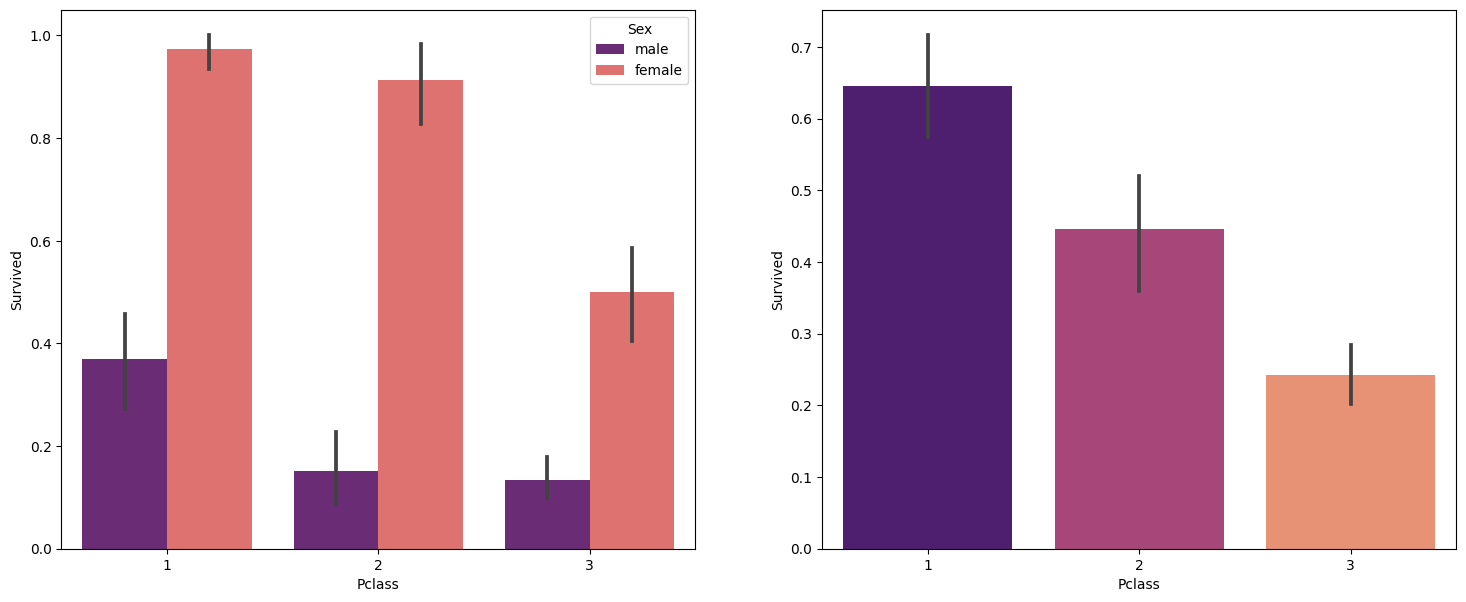

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(train_df, x='Pclass', y='Survived', hue='Sex', palette='magma', ax=axes[0])
sns.barplot(train_df, x='Pclass', y='Survived', palette='magma', ax=axes[1])
plt.show()

<p style="background-color: #32656e"><i>Looks like higher social class people had higher chance of survival, especially female passengers.</i></p>

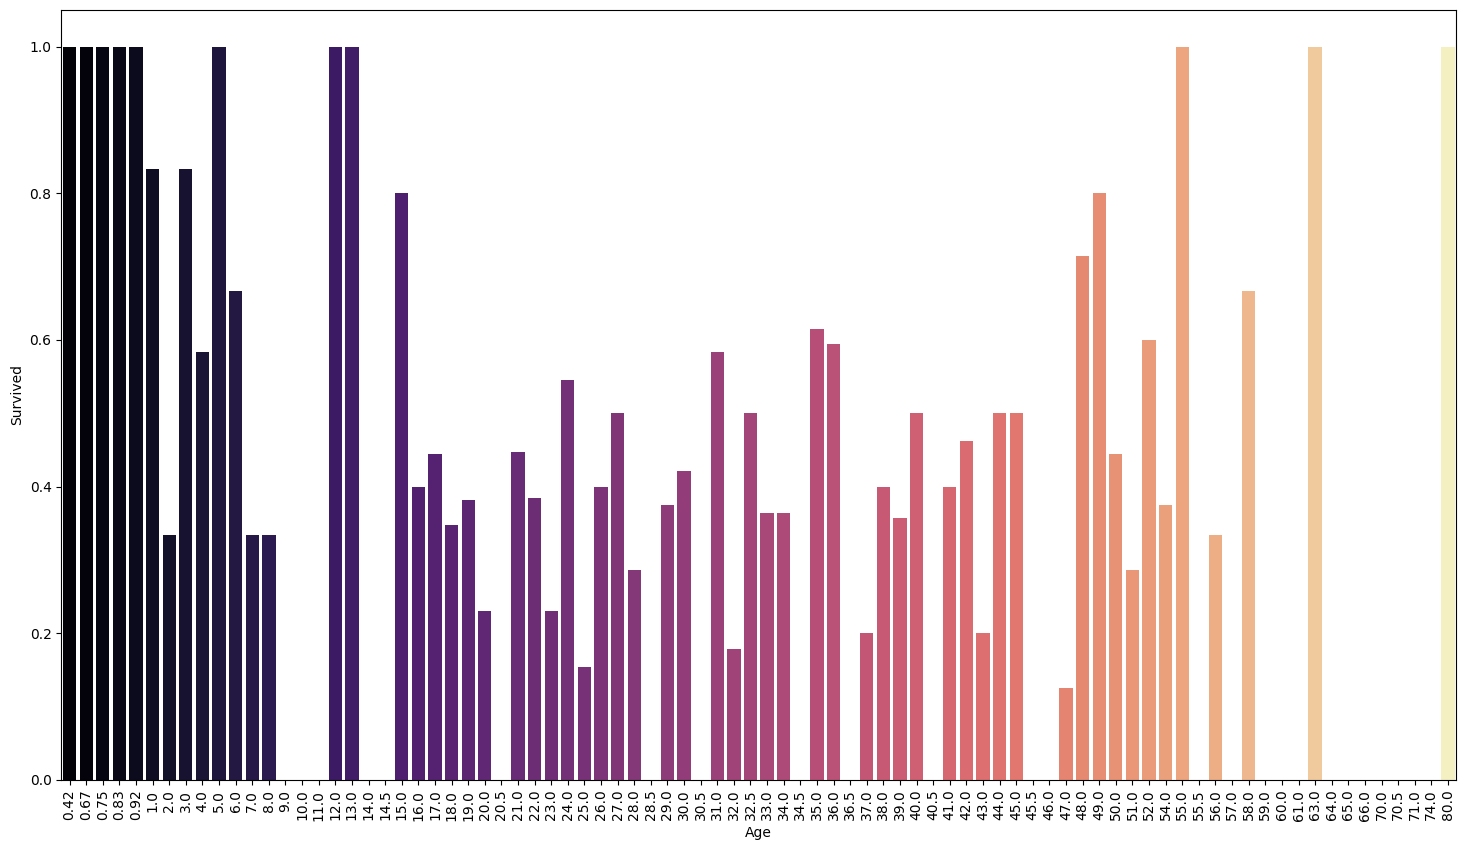

In [53]:
plt.figure(figsize=(18, 10))
ax = sns.barplot(train_df, x='Age', y='Survived', palette='magma', errorbar=None)

    
plt.xticks(rotation=90)
plt.show()

<p style="background-color: #32656e"><i>Let's aggregate <b><i>Age</i></b> into several groups.</i></p>

In [54]:
# group train_df
train_df['Age_group'] = train_df.Age.copy()

train_df.loc[train_df.Age<=18, 'Age_group'] = 0
train_df.loc[(train_df.Age>18)&(train_df.Age<=30), 'Age_group'] = 1
train_df.loc[(train_df.Age>30)&(train_df.Age<=45), 'Age_group'] = 2
train_df.loc[(train_df.Age>45)&(train_df.Age<=55), 'Age_group'] = 3
train_df.loc[(train_df.Age>55), 'Age_group'] = 4

# group test_df
test_df['Age_group'] = test_df.Age.copy()

test_df.loc[test_df.Age<=18, 'Age_group'] = 0
test_df.loc[(test_df.Age>18)&(test_df.Age<=30), 'Age_group'] = 1
test_df.loc[(test_df.Age>30)&(test_df.Age<=45), 'Age_group'] = 2
test_df.loc[(test_df.Age>45)&(test_df.Age<=55), 'Age_group'] = 3
test_df.loc[(test_df.Age>55), 'Age_group'] = 4

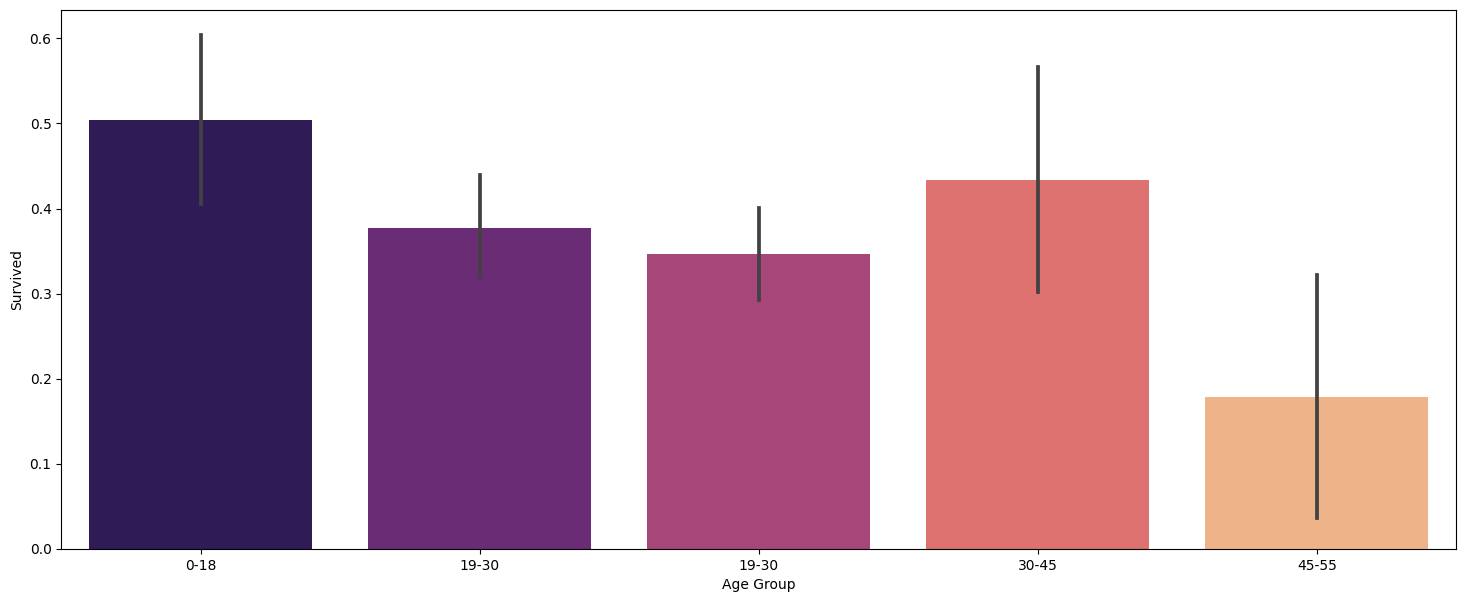

In [55]:
plt.figure(figsize=(18, 7))

ax = sns.barplot(train_df, x='Age_group', y='Survived', palette='magma')

x_ticks = ax.get_xticks().tolist()
sub_list = ["0-18", "19-30", "19-30", "30-45", "45-55", "55-80"]
for idx in range(len(x_ticks)):
    x_ticks[idx] = sub_list[idx]
ax.set_xticklabels(x_ticks)
plt. xlabel('Age Group')

plt.show;

<p style="background-color: #32656e"><i>Well, what do you know! Guess it's more visible which age group has better chance of survival.</i></p>

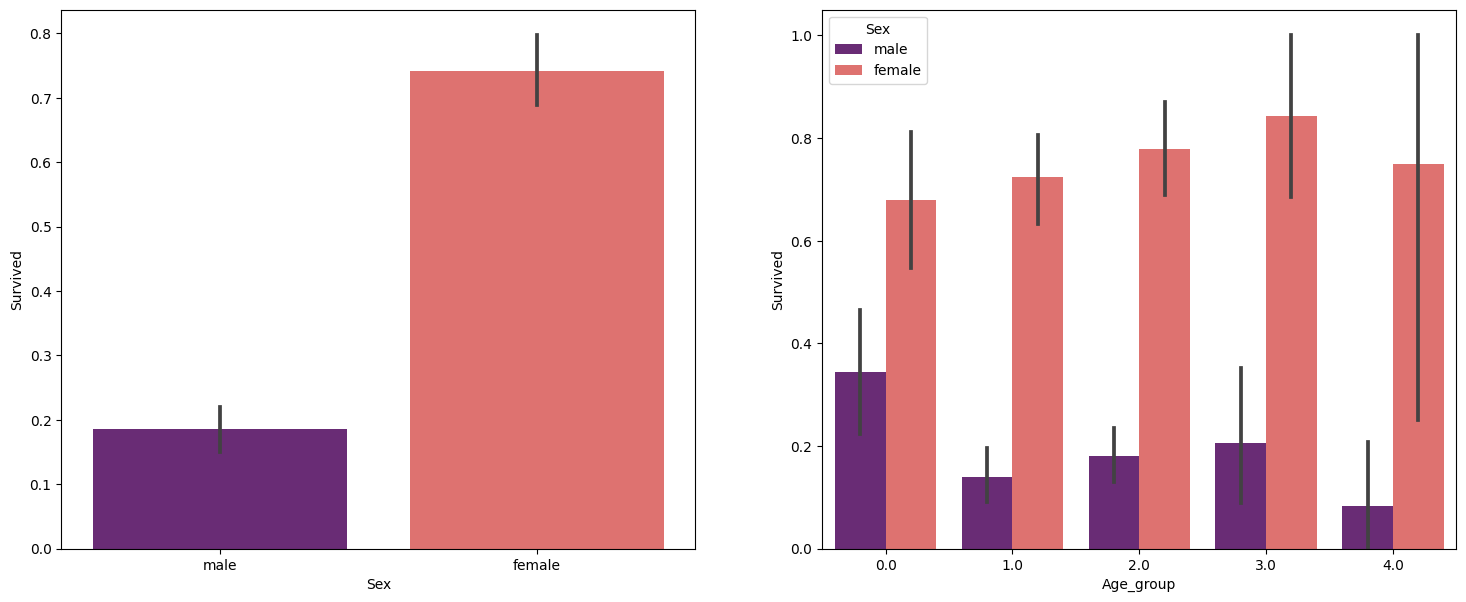

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(train_df, x='Sex', y='Survived', palette='magma',  ax=axes[0])
sns.barplot(train_df, x='Age_group', y='Survived', hue='Sex', palette='magma',  ax=axes[1])
plt.show;

<p style="background-color: #32656e"><i>In general, femlae passengers had better chance of survival. combining it with age, we can see that female passenger survival chance increases as we move to higher age group, while in contrast, male passengers chances decline.</i></p>

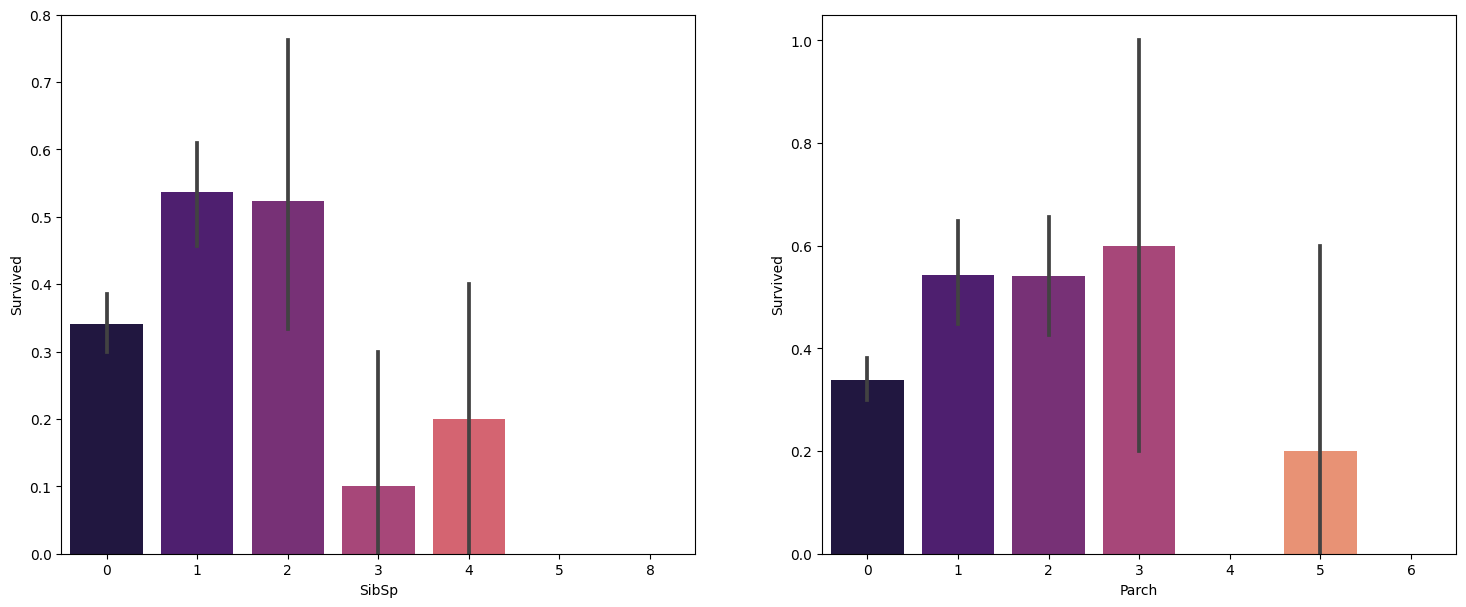

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(train_df, x='SibSp', y='Survived', palette='magma',  ax=axes[0])
sns.barplot(train_df, x='Parch', y='Survived', palette='magma',  ax=axes[1])
plt.show;

<p style="background-color: #32656e"><i>Let's aggregate these two variables into several groups.</i></p>

In [58]:
# group SibSp train_df
train_df['SibSp_group'] = train_df.SibSp.copy()
train_df.loc[train_df.SibSp==0, 'SibSp_group'] = 0
train_df.loc[train_df.SibSp.isin([1, 2]), 'SibSp_group'] = 1
train_df.loc[train_df.SibSp>=3, 'SibSp_group'] = 2

# group SibSp test_df
test_df['SibSp_group'] = test_df.SibSp.copy()
test_df.loc[test_df.SibSp==0, 'SibSp_group'] = 0
test_df.loc[test_df.SibSp.isin([1, 2]), 'SibSp_group'] = 1
test_df.loc[test_df.SibSp>=3, 'SibSp_group'] = 2

# group Parch train_df
train_df['Parch_group'] = train_df.Parch.copy()
train_df.loc[train_df.Parch==0, 'Parch_group'] = 0
train_df.loc[train_df.Parch.isin([1, 2, 3]), 'Parch_group'] = 1
train_df.loc[train_df.Parch>=4, 'Parch_group'] = 2

# group Parch test_df
test_df['Parch_group'] = test_df.Parch.copy()
test_df.loc[test_df.Parch==0, 'Parch_group'] = 0
test_df.loc[test_df.Parch.isin([1, 2, 3]), 'Parch_group'] = 1
test_df.loc[test_df.Parch>=4, 'Parch_group'] = 2


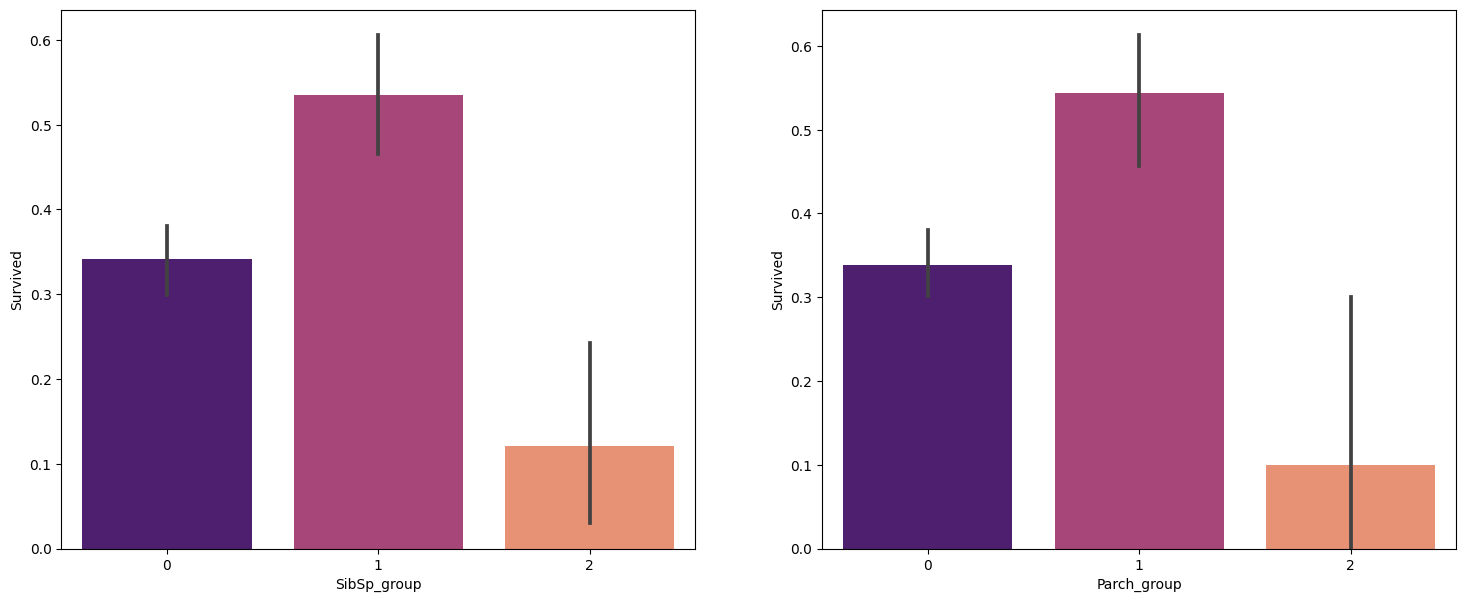

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(train_df, x='SibSp_group', y='Survived', palette='magma',  ax=axes[0])
sns.barplot(train_df, x='Parch_group', y='Survived', palette='magma',  ax=axes[1])
plt.show;

<p style="background-color: #32656e"><i>Looks like those that were alone on the ship without any relative were less likely to survive than those in a with a small group of relatives. But Those with a big group of relatives are least likely to survive</i></p>

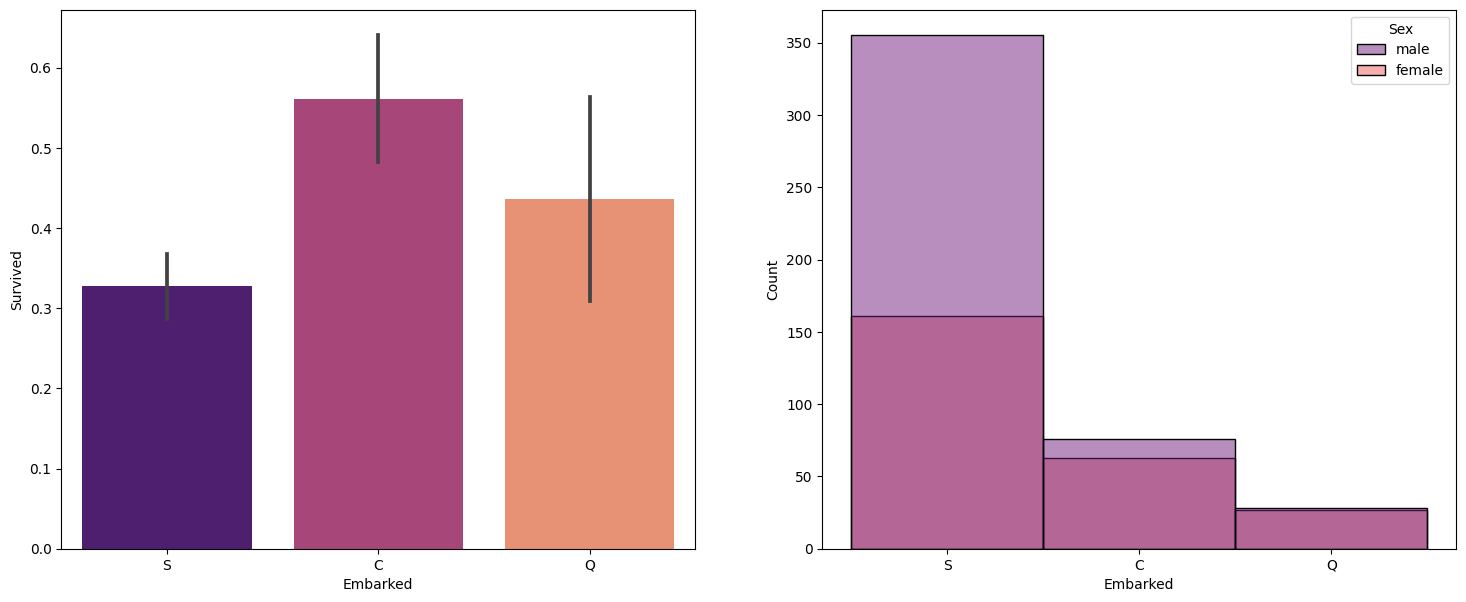

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(train_df, x='Embarked', y='Survived', palette='magma', ax=axes[0])
sns.histplot(train_df, x='Embarked', hue='Sex', palette='magma',  ax=axes[1])
plt.show;

<p style="background-color: #32656e"><i>Looks like those that embarked in Southampton are less likely to survive. That could be explained by the fact that in Southampton twice as much male passengers got onto ship as female. In other two ports passenger gender were more balanced and they thus they are more likely to survive than those embarked in Southampton. Though, there is still difference between Cherbourg and Queenstown passenger survival rate that could not be explained by gender distribution.</i></p>

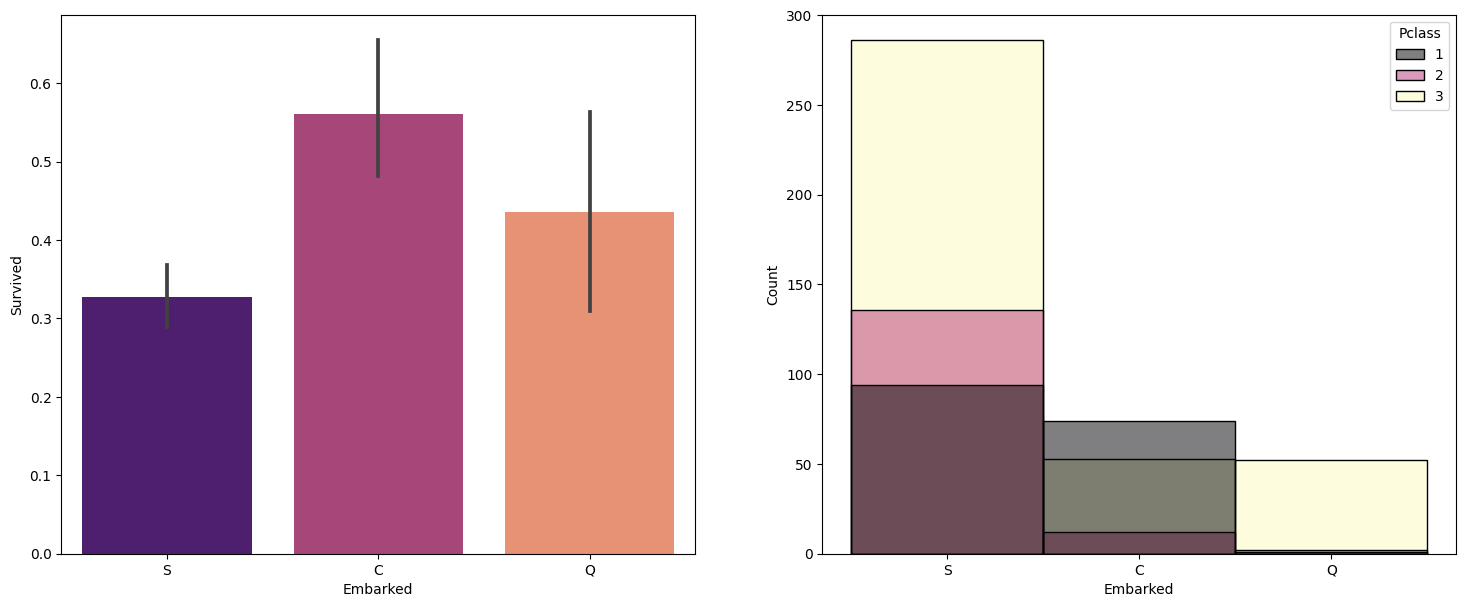

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(train_df, x='Embarked', y='Survived', palette='magma', ax=axes[0])
sns.histplot(train_df, x='Embarked', hue='Pclass', palette='magma',  ax=axes[1])
plt.show;

<p style="background-color: #32656e"><i>In addition to gender effect, looks like in Southampton and Queenstown a lot of lower class passengers embarked while more than half of passengers were from higher class in Cherbourg. Thus, Cherbourg passengers had more chance of survival. Now there is one thing, passengers from Queenstown moslty belonged to lower class, while in Southampton more than half of passengers belonged to middle or higher classes. Still Queenstown passengers survival rate is higher than Southampton passengers.</i></p>

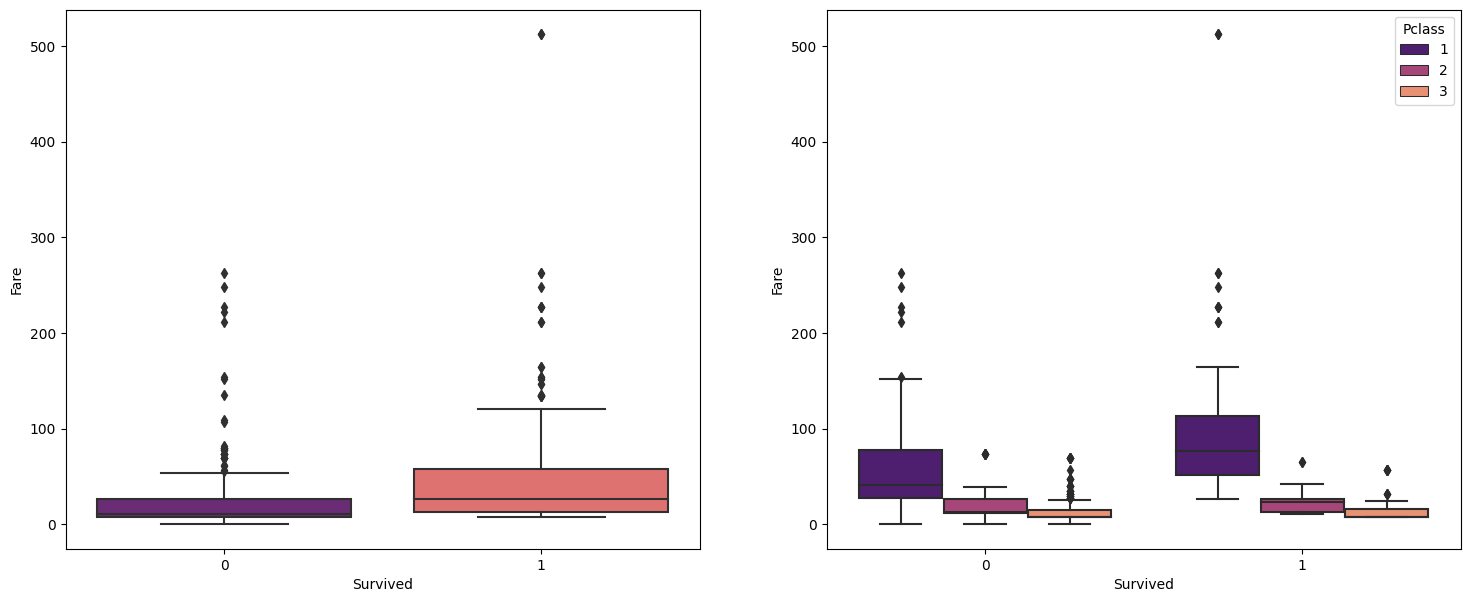

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.boxplot(train_df, x='Survived', y='Fare', palette='magma', ax=axes[0])
sns.boxplot(train_df, x='Survived', y='Fare', hue='Pclass', palette='magma',  ax=axes[1])
plt.show;

<p style="background-color: #32656e"><i>Well, people that survived paid hire fare to get onto the ship. Moreover, this is accounted for mostly by higher class passengers. Aslo, higher class passengers that survived paid more than those higher class passengers that died, on average. There are outliers so let's drop them using Interquartile Range method (separately for both Survived cateogry).</i></p>

In [63]:
Q1 = train_df['Fare'].quantile(0.25)
Q3 = train_df['Fare'].quantile(0.75)

IQR= Q3-Q1
upper_limit = Q3+1.5*IQR
lower_limit = max(Q1-1.5*IQR, 0.0)
drop_idx = train_df.loc[(train_df.Fare>upper_limit)|(train_df.Fare<lower_limit)].index
train_df.drop(drop_idx, inplace=True)

<p style="background-color: #32656e"><i>That's all the variables. We can drop <b><i>Ticket</i></b> because it's just ticket number and I could not get anything useful from it. We can also drop <b><i>Name, Age_group, SibSp_group, Parch_group and Honorifics</i></b> as they have already served their purpose. Other than that, let's get to training some models.</i></p>

In [65]:
train_df.drop(['Ticket', 'Name', 'Age_group', 'SibSp_group', 'Parch_group', 'Honorifics'], axis=1, inplace=True)
test_df.drop(['Ticket', 'Name', 'Age_group', 'SibSp_group', 'Parch_group', 'Honorifics'], axis=1, inplace=True)

In [66]:
# We've got two nominal categorical variables so let's get dummies for them
train_df = pd.get_dummies(train_df, prefix_sep='_', columns=['Sex', 'Embarked'], drop_first=True, dtype='int')
test_df = pd.get_dummies(test_df, prefix_sep='_', columns=['Sex', 'Embarked'], drop_first=True, dtype='int')

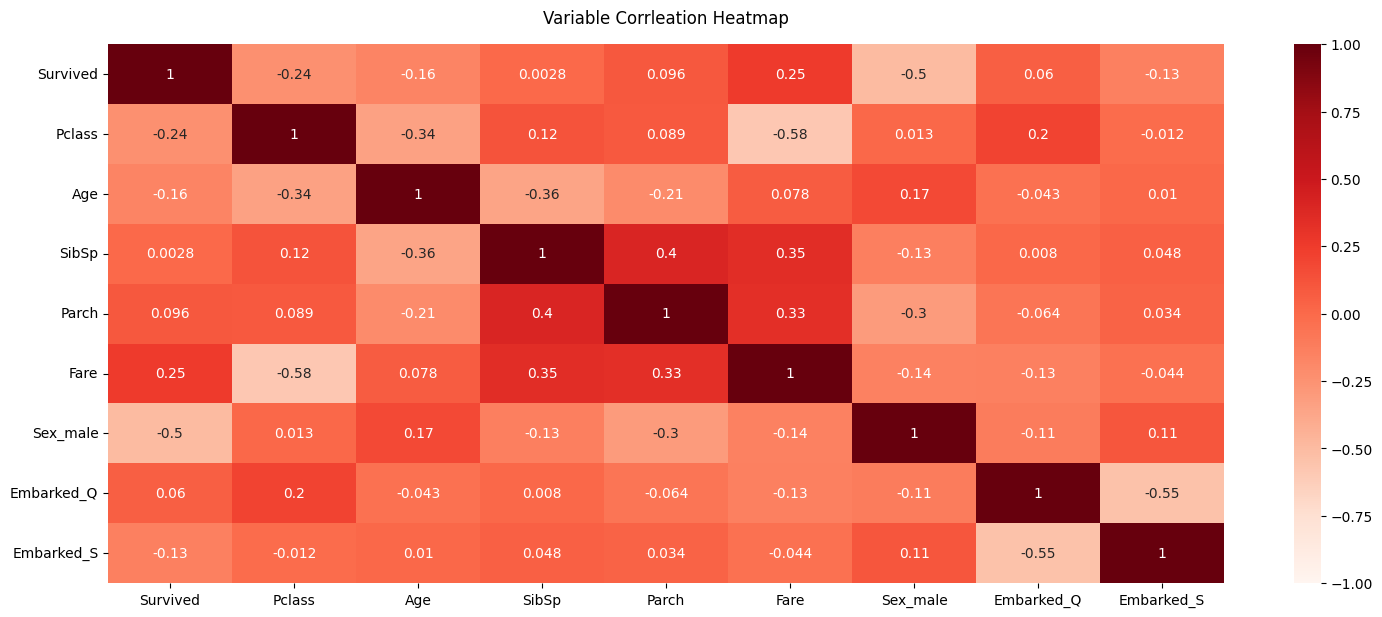

In [87]:
plt.figure(figsize=(18, 7))
fig = sns.heatmap(train_df.corr(), vmin=-1, vmax=1, annot=True, cmap='Reds');
fig.set_title('Variable Corrleation Heatmap', pad=15)
plt.show;

<p style="background-color: #32656e"><i>Sure there are some correlations between independent variables (Pclass and Fare, Embarked_Q and Embarked_S) but they are not that high. So, there is no multicollinearity problem.</i></p>

# Train Models

In [70]:
param_grid = {
    "n_estimators" : [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    "max_depth" : [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "min_samples_split" : [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

In [71]:
model = RandomForestClassifier(random_state=0)
randomized_search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
randomized_search.fit(train_df.drop('Survived', axis=1), train_df['Survived'])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90, 100],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [72]:
randomized_search.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 20,
 'criterion': 'gini',
 'bootstrap': True}

In [77]:
model = RandomForestClassifier(
    n_estimators = 400, min_samples_split = 2, min_samples_leaf = 2,
    max_depth = 20, criterion = 'gini', bootstrap = True
    )
model.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
predictions = model.predict(test_df.drop('Survived', axis=1))
accuracy = accuracy_score(test_df.Survived.values.ravel(), predictions)
print('Test Set Accuracy:', (accuracy*100).round(2))

Test Set Accuracy: 81.01


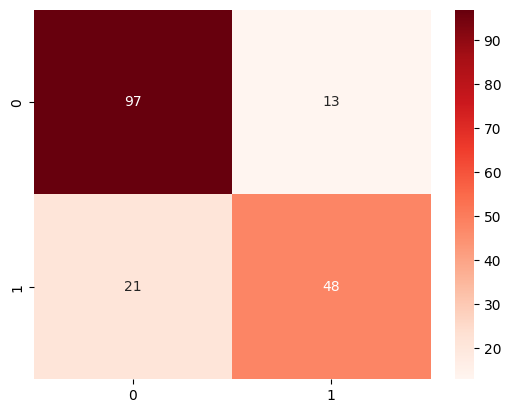

In [84]:
sns.heatmap(confusion_matrix(test_df['Survived'], predictions), cmap="Reds", annot=True)
plt.show();

In [86]:
# Save model using pickle
model_Pickle = open('model_Pickle', 'wb') 
pickle.dump(model, model_Pickle)
model_Pickle.close()